<a href="https://colab.research.google.com/github/gowtham66866/Inkers/blob/master/Assignment_9A_CIFAR10_Grad_CAM_cutout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# ls /content/gdrive/My\ Drive/EVA

In [3]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# from random_eraser import get_random_eraser

Using TensorFlow backend.


In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [5]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


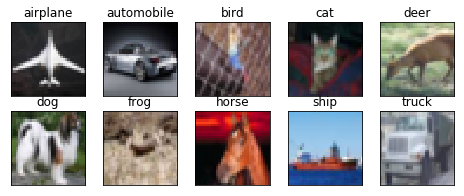

In [6]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [10]:
from keras import regularizers
weight_decay = 0.0005
    
model = Sequential()


# first convolution block
model.add(Convolution2D(32, (3, 3), padding='same',
                         input_shape=[32,32,3],kernel_regularizer=regularizers.l2(weight_decay))) #32
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Convolution2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))) #32
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Convolution2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))) #32
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

# first transition block with bottlneck
model.add(MaxPooling2D(pool_size=(2, 2)))   #16
model.add(Convolution2D(32, 1, 1, activation='relu'))


# second convolution block
model.add(Convolution2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))  #16
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Convolution2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))  #16
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

# second transition block with bottlneck
model.add(MaxPooling2D(pool_size=(2, 2)))  #8
model.add(Convolution2D(32, 1, 1, activation='relu'))

# third convolution block
model.add(Convolution2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))  #8
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Convolution2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))  #8
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Convolution2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))   #18
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

# third transition block with bottlneck
model.add(MaxPooling2D(pool_size=(2, 2)))   #4
model.add(Convolution2D(32, 1, 1, activation='relu'))

# fourth convolution block
model.add(Convolution2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))) #4
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Convolution2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay))) #4
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Convolution2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))#4
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

# fourth transition block with bottlneck
model.add(MaxPooling2D(pool_size=(2, 2))) #2
model.add(Convolution2D(64, 1, 1, activation='relu'))


# fifth convolution block
model.add(Convolution2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))  #2
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Convolution2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))  #2
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

# fifth transition block with bottlneck
model.add(MaxPooling2D(pool_size=(2, 2)))   #1
model.add(Convolution2D(32, 1, 1, activation='relu'))

# final convolution block
model.add(Convolution2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))  #1
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Convolution2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))  #1
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Convolution2D(10, (3, 3), padding='same'))

# model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Activation('softmax'))
model.summary()

W0721 16:40:44.497615 140126747371392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 16:40:44.533758 140126747371392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 16:40:44.541641 140126747371392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0721 16:40:44.584463 140126747371392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0721 16:40:44.585564 1401267473

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
__________

In [11]:
from keras.optimizers import adam
adam = adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8,decay=0.005)
model.compile(loss='categorical_crossentropy',
             optimizer=adam,
             metrics=['accuracy'])

W0721 16:40:52.450437 140126747371392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### cutout
Image augmentation incudes cutout, resulting in 1.5% improvement in validation accuracy.
I am saving this model, to be used for calculating grad-CAM.


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<keras.ca..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
W0721 16:40:58.640244 140126747371392 deprecation.py

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 45s 116ms/step - loss: 5.1153 - acc: 0.2060 - val_loss: 3.3941 - val_acc: 0.1038

Epoch 00001: val_loss improved from inf to 3.39409, saving model to /content/gdrive/My Drive/epochs:001-val_acc:0.104.hdf5
Epoch 2/100
390/390 [==============================] - 38s 97ms/step - loss: 2.5683 - acc: 0.2839 - val_loss: 2.7085 - val_acc: 0.1573

Epoch 00002: val_loss improved from 3.39409 to 2.70845, saving model to /content/gdrive/My Drive/epochs:002-val_acc:0.157.hdf5
Epoch 3/100
390/390 [==============================] - 36s 92ms/step - loss: 2.1189 - acc: 0.3308 - val_loss: 2.2811 - val_acc: 0.2737

Epoch 00003: val_loss improved from 2.70845 to 2.28111, saving model to /content/gdrive/My Drive/epochs:003-val_acc:0.274.hdf5
Epoch 4/100
390/390 [==============================] - 36s 92ms/step - loss: 1.9268 - acc: 0.3828 - val_loss: 2.1937 - val_acc: 0.3379

Epoch 00004: val_loss improved from 2.28111 to 2.19373, saving model to /content/gdrive/My

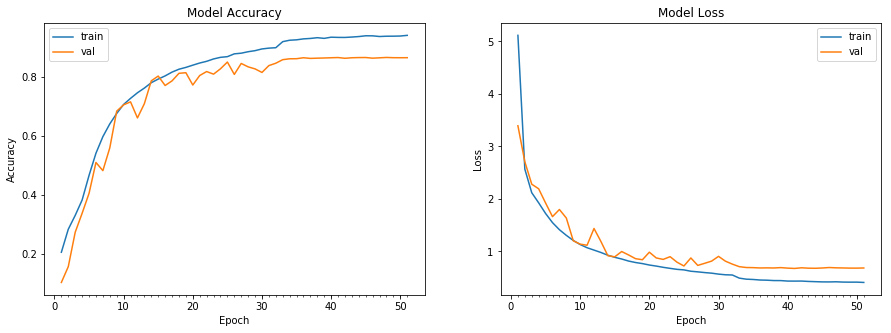

Accuracy on test data is: 86.46


In [12]:
from keras.preprocessing.image import ImageDataGenerator
random_erasing = True
pixel_level = False

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=pixel_level))

filepath="/content/gdrive/My Drive/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(filepath, save_best_only=True,verbose=1, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 callbacks = [earlyStopping, mcp_save, reduce_lr_loss],
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
from google.colab.patches import cv2_imshow

In [0]:
# (train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

In [0]:
# # model = VGG16(weights="imagenet")
# # img_path = "car.jpeg"
# # img = image.load_img(img_path, target_size=(224, 224))
# # x = image.img_to_array(img)
# num = 55
# x = test_data[num]
# print(np.shape(x))
# x = image.img_to_array(x)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# print(np.shape(x))
# print(x.dtype)

In [0]:
# preds = model.predict(x)
# print(np.shape(preds))
# class_idx = np.argmax(preds[0])
# class_output = model.output[:, class_idx]
# print(class_output)
# last_conv_layer = model.get_layer("conv2d_83")
# print(last_conv_layer)

In [0]:
# grads = K.gradients(class_output, last_conv_layer.output)[0]
# pooled_grads = K.mean(grads, axis=(0, 1, 2))
# iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
# pooled_grads_value, conv_layer_output_value = iterate([x])
# # print(np.shape(conv_layer_output_value))
# for i in range(256):
# #     print(i)
#     conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
# print(np.shape(conv_layer_output_value))
# heatmap = np.mean(conv_layer_output_value, axis=-1)
# print(np.shape(heatmap))
# heatmap = np.maximum(heatmap, 0)
# heatmap /= np.max(heatmap)

In [0]:
# # from google.colab.patches import cv2_imshow
# import matplotlib.pyplot as plt

# %matplotlib inline

# # img = cv2.imread(img_path)
# org = test_features[num]
# img = test_features[num].astype(np.uint8)
# heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# print(np.shape(heatmap),heatmap.dtype)
# heatmap = np.uint8(255 * heatmap)
# # heatmap = np.float32(255 * heatmap)
# print(np.shape(heatmap))
# heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# print(np.shape(heatmap),np.shape(img),type(img),type(heatmap))
# print(img.dtype,heatmap.dtype)
# # img = img.astype(np.uint8)
# print(img.dtype,heatmap.dtype)
# superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
# # cv2.imshow("Original", img)
# # cv2.imshow("GradCam", superimposed_img)
# # cv2.waitKey(0)
# # display images
# fig, ax = plt.subplots(1,2)
# ax[0].imshow(org)
# ax[1].imshow(superimposed_img)
# # plt.imshow(superimposed_img)
# # plt.show()

In [0]:
# # from google.colab.patches import cv2_imshow
# import matplotlib.pyplot as plt

# %matplotlib inline

# # img = cv2.imread(img_path)
# org = test_features[num]
# img = test_features[num].astype(np.uint8)
# heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# heatmap = np.uint8(255 * heatmap)
# # heatmap = np.float32(255 * heatmap)
# heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# print(img.dtype,heatmap.dtype)
# # img = img.astype(np.uint8)
# print(img.dtype,heatmap.dtype)
# print(type(img),type(heatmap))
# superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
# superimposed_img11 = cv2.addWeighted(img, 1, heatmap, 0, 0)
# superimposed_img22 = cv2.addWeighted(img, 0, heatmap, 1, 0)
# print(superimposed_img.dtype)
# superimposed_img = superimposed_img.astype(np.float32)
# # display images
# fig, ax = plt.subplots(1,4)
# ax[0].imshow(org)
# ax[1].imshow(superimposed_img)
# ax[2].imshow(superimposed_img11)
# ax[3].imshow(superimposed_img22)
# # plt.imshow(superimposed_img)
# # plt.show()

In [21]:
from google.colab import files
files.upload()

{}

In [0]:
# img_path = "dog.jpg"
# img = image.load_img(img_path, target_size=(32, 32))
img = test_features[3]
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [23]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_146")

ValueError: ignored

In [24]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(10):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

NameError: ignored

In [25]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

NameError: ignored

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline
# img = cv2.imread(img)
org = img
img = image.img_to_array(img)
print(np.shape(img))
print(img.dtype)
img = cv2.resize(img, (32,32))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
print(np.shape(heatmap))
heatmap = np.uint8(255 * heatmap)
print(np.shape(heatmap))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print(np.shape(heatmap),np.shape(img))
print(img.dtype,heatmap.dtype)
superimposed_img = cv2.addWeighted(np.uint8(img), 0.6, heatmap, 0.4, 0)
# cv2.imshow("Original", img)
# cv2.imshow("GradCam", superimposed_img)
# cv2.waitKey(0)
# plt.imshow(superimposed_img)
# plt.show()
# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(org)
ax[1].imshow(superimposed_img)

(32, 32, 3)
float32


NameError: ignored

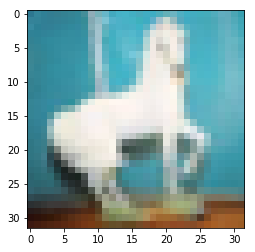

In [27]:
num = 1100
img = test_features[num]
plt.imshow(img)
plt.show()

In [28]:
x = np.expand_dims(img, axis=0)
preds = model.predict(x)
print(preds)
print(np.max(preds))
print(np.argmax(preds))
print(class_names[np.argmax(preds)])
print(class_names[np.argmax(train_labels[num])])

[[0.03973625 0.03752863 0.11204014 0.44877908 0.00406979 0.21191613
  0.01863282 0.02928117 0.09087124 0.00714479]]
0.44877908
3
cat
cat


In [29]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']